Importamos las librerias necesarias

In [1]:
import numpy as np
import pandas as pd
import GPy
import os
from scipy.stats import kstest
from Functions.utils import get_df_symbols, get_corr
from Functions.strategy import Strategy
from Functions.backtesting import BackTesting
from Functions.backtesting import total_backtesting
%matplotlib inline

Leemos el fichero de texto que contiene los futuros con los que operaremos y descargamos los mismos a través de la API de yahoo finance.

In [2]:
symbols = pd.read_csv('futures.txt', sep=';', header = 0)

In [3]:
datasets = get_df_symbols(symbols, verbose=True)

Getting Gold dataset
Getting Petroleum WTI dataset
Getting Natural Gas dataset
Getting Silver dataset
Getting RBOB Gasoline dataset
Getting Heating Oil dataset
Getting Platinum dataset
Getting Copper dataset
Getting Palladium dataset
Getting Corn Futures dataset
Getting Rough Rice Futures dataset
Getting Soybean Futures dataset
Getting Cocoa dataset
Getting Coffee dataset
Getting Cotton dataset
Getting Sugar dataset


Construimos el dataset que contiene los precios de cierre de todas las series anteriormente descargadas.

In [4]:
df_closes = pd.DataFrame(columns=list(datasets.keys()))
for name in list(datasets.keys()):
    df_closes[name] = datasets[name]['Adj Close']

Estudiamos la correlación entre las series de precios de cierre de los distintos futuros. Para ello, primero estudiamos la normalidad de dichas series.

In [5]:
for name in df_closes.columns:
    print(name + ':', kstest(df_closes[name].dropna(), 'norm').pvalue)

Gold: 0.0
Petroleum WTI: 0.0
Natural Gas: 0.0
Silver: 0.0
RBOB Gasoline: 0.0
Heating Oil: 0.0
Platinum: 0.0
Copper: 0.0
Palladium: 0.0
Corn Futures: 0.0
Rough Rice Futures: 0.0
Soybean Futures: 0.0
Cocoa: 0.0
Coffee: 0.0
Cotton: 0.0
Sugar: 0.0


Las series de precios anteriores no están normalmente distribuidas, por lo que lo más apropiado es estudiar la correlación por el método de Spearman en lugar de Pearson. Además, como simularemos haber operado en el mercado con nuestra estrategia durante los últimos 10 años (desde 2012 hasta 2021,ambos incluidos), estudiaremos las correlaciones entre series con datos hasta 2011.

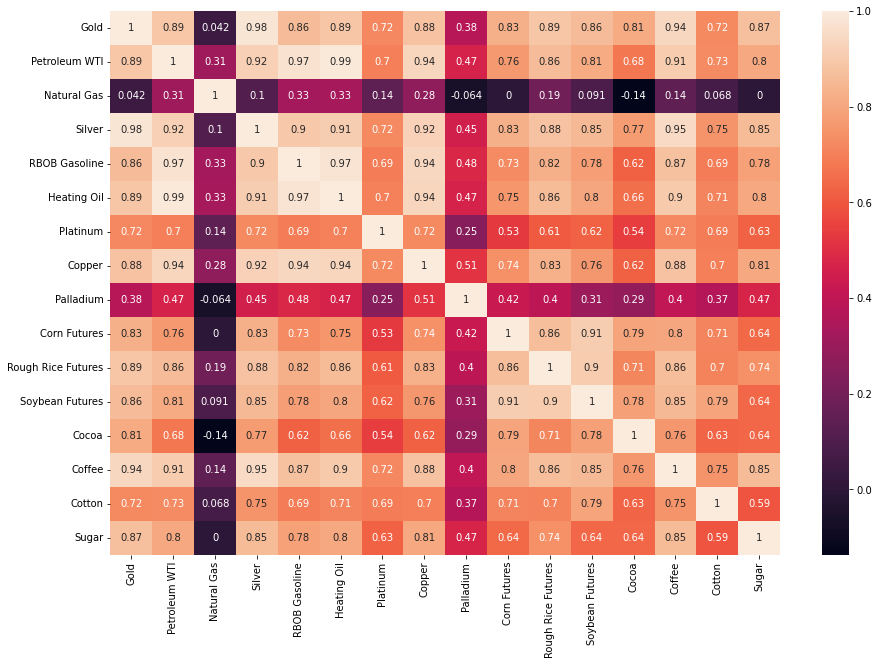

In [6]:
top_3_corr = get_corr(datasets, n=3, year=2011, method='spearman', alpha=0.05, plot=True, save='Correlation')

Definimos el kernel del Proceso Gaussiano que emplearemos para calcular las predicciones de los precios de las materias primas.

In [7]:
kernel_dim = 6
k1 = GPy.kern.Bias(input_dim=kernel_dim)
k2 = GPy.kern.RatQuad(input_dim=kernel_dim, ARD=True)
k3 = GPy.kern.Bias(input_dim=kernel_dim)
k4 = GPy.kern.White(input_dim=1)
kernel = k1 * k2 + k3 * k4

Simulamos operar en el mercado de materias primas desde 2011 hasta 2021 obteniendo las decisiones de compra y venta que la estrategia hubiese tomado para cada uno de los futuros teniendo datos hasta ese instante. Además, almacenamos estas mismas decisiones en ficheros de texto para su posterior estudio.

In [8]:
years_pred, days_before, years_before = range(2011, 2022), 60, 3

strategies, i = {}, 1
for name in list(datasets.keys()):
    print('Predicting ' + name)
    strategies_name = {}
    for year_pred in years_pred:
        show = True if i % 1e+5 == 0 else False
        save = name + '{}_{}_{}'.format(year_pred, days_before, years_before)
        strategy = Strategy(df=datasets[name], df_s1=datasets[top_3_corr[name][0]], df_s2=datasets[top_3_corr[name][1]], df_s3=datasets[top_3_corr[name][2]],
                            kernel=kernel, year_pred=year_pred, years_before=years_before, days_before=days_before, max_iter=50,
                            verbose=show, verbose_kernel=show, plot_strategy=show, plot_prediction=show, save=save,
                            time_pen=0.99, days_between_rows=1, days_between_deltas=1, num_inducing=1000)

        strategy.execute()
        strategies_name[str(year_pred)] = strategy
        i += 1
    strategies[name] = strategies_name

Predicting Gold
Predicting Petroleum WTI
Predicting Natural Gas
Predicting Silver
Predicting RBOB Gasoline
Predicting Heating Oil
Predicting Platinum
Predicting Copper
Predicting Palladium
Predicting Corn Futures
Predicting Rough Rice Futures
Predicting Soybean Futures
Predicting Cocoa
Predicting Coffee
Predicting Cotton
Predicting Sugar


In [9]:
actions = {}
for name in list(strategies.keys()):
    df = pd.DataFrame(columns=['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'Action'])
    for year in years_pred:
        df_year = pd.DataFrame(datasets[name][['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close']].loc[str(year)])
        df_year['Action'] = strategies[name][str(year)].action
        df = pd.concat([df, df_year.reset_index()])
    actions[name] = df.reset_index(drop=True)

for name in list(actions.keys()):
    actions[name][['Date', 'High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'Action']].to_csv('Actions/Actions/' + name + '_{}{}_{}_{}.csv'.format(min(years_pred), max(years_pred), days_before, years_before), index=False)

Estudiamos los resultados que la estrategia hubiese obtenido de operar desde 2011 hasta 2021 para cada uno de los futuros y el resultado global de operar en todos a la vez.

In [2]:
names, actions = os.listdir('Actions/Actions/'), {}
years_pred, days_before, years_before = range(int(names[0].split('_')[1][:4]), int(names[0].split('_')[1][4:]) + 1), int(names[0].split('_')[2]), int(names[0].split('_')[3][:-4])
for name in names:
    df = pd.read_csv('Actions/Actions/' + name)
    df['Date'] = df['Date'].apply(lambda x: np.datetime64(x))
    actions[name.split('_')[0]] = df

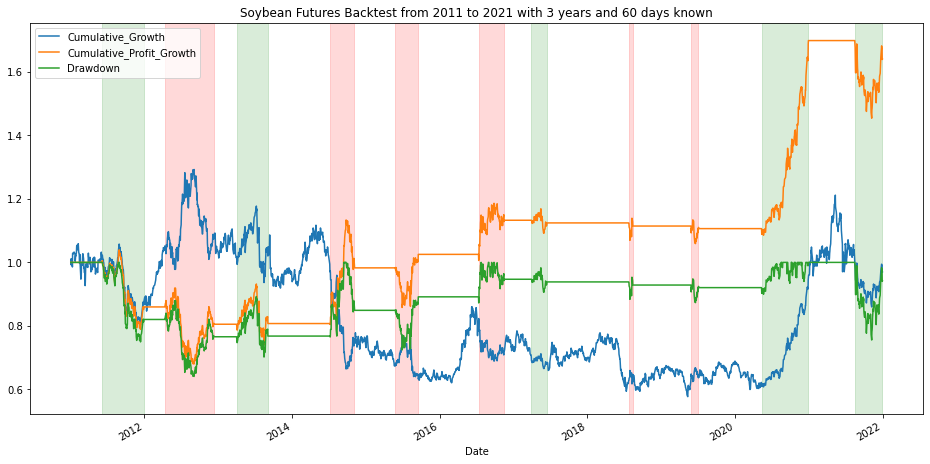

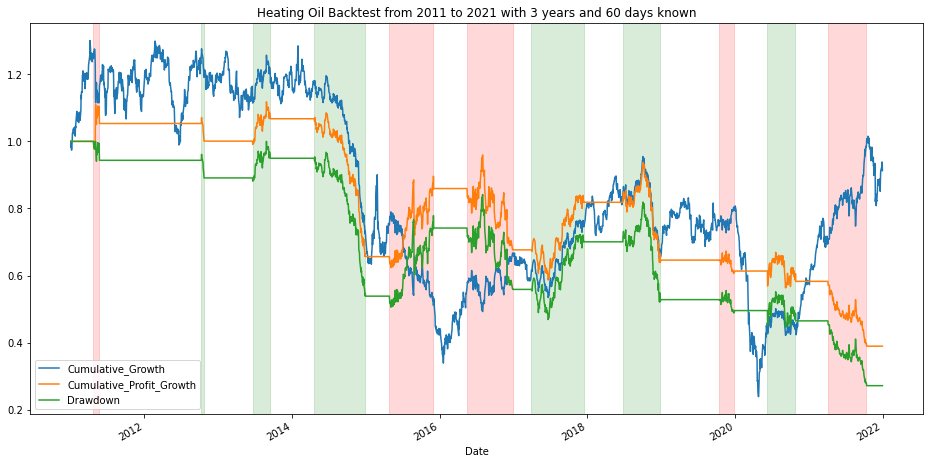

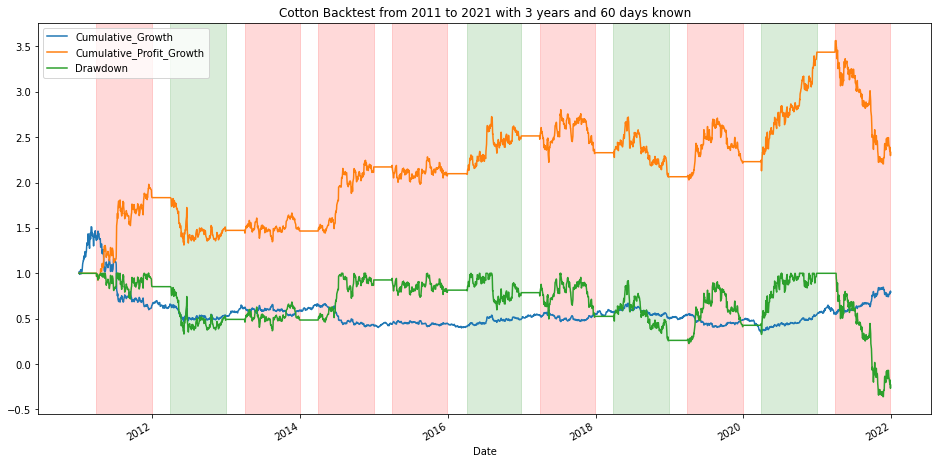

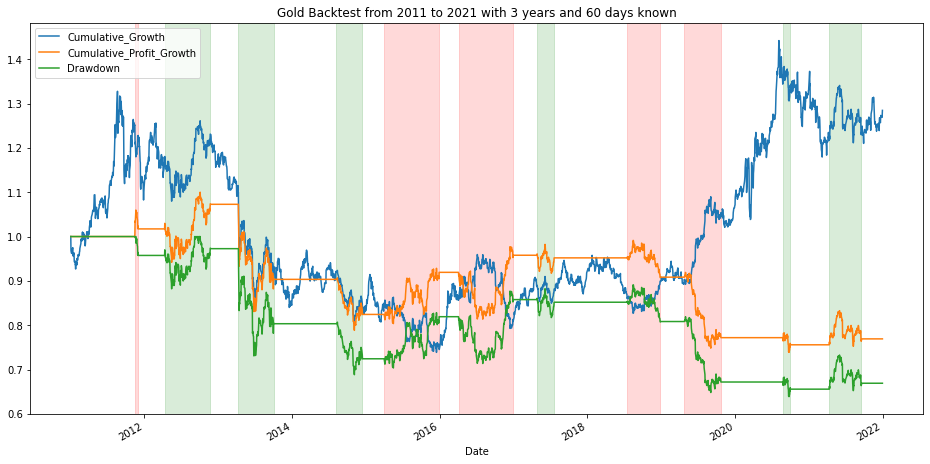

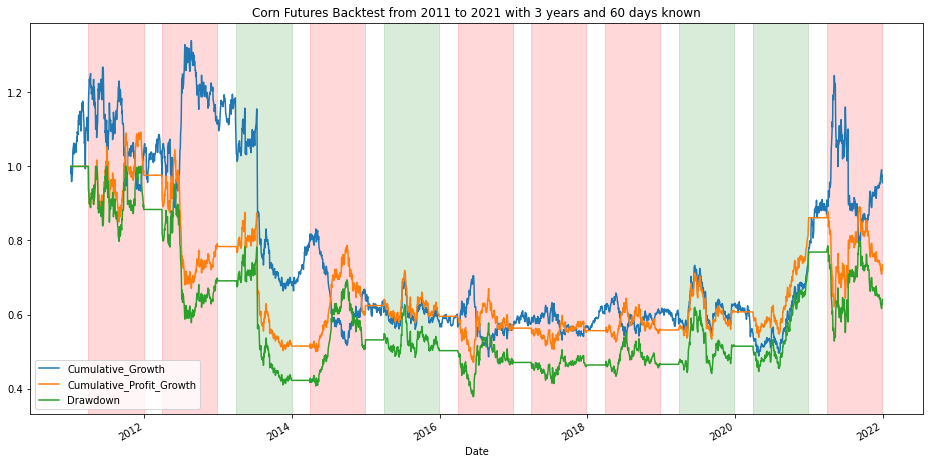

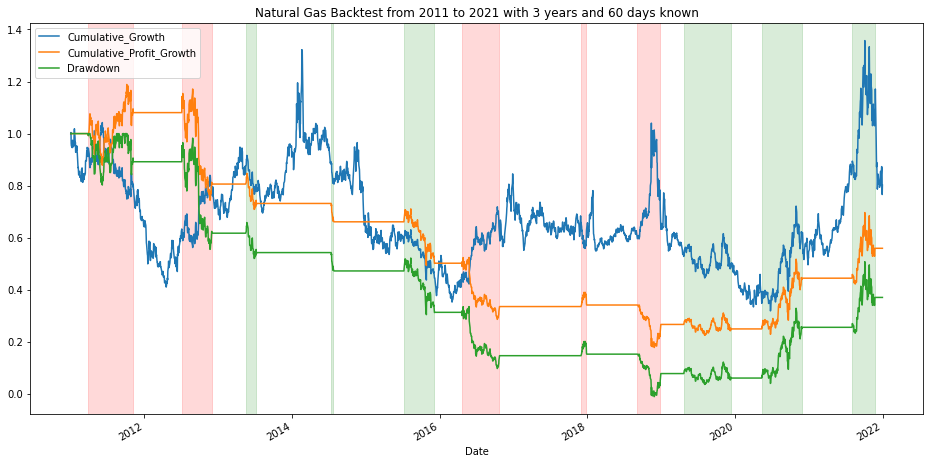

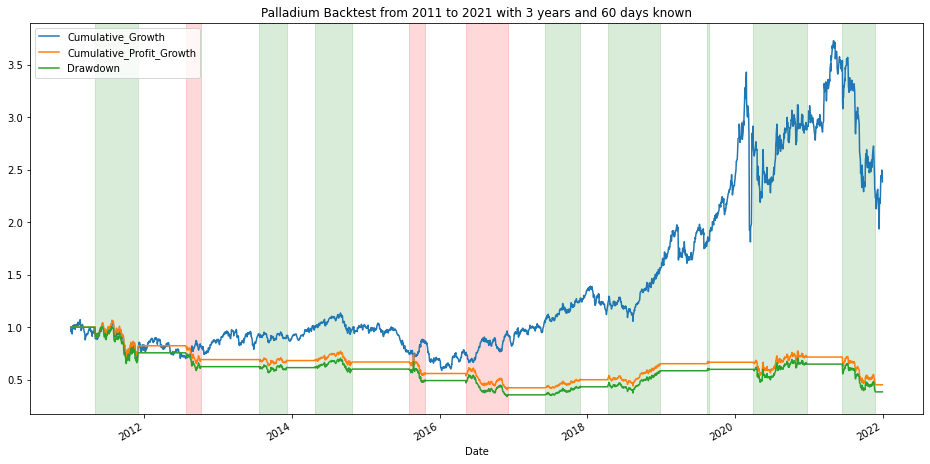

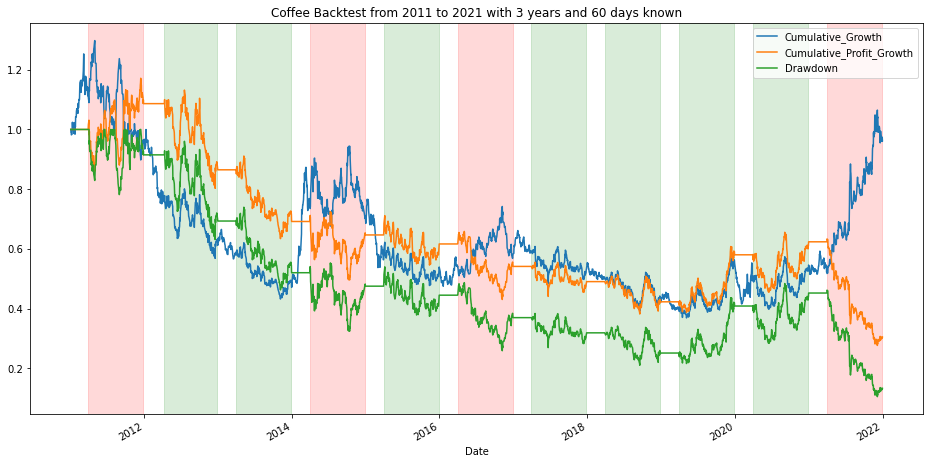

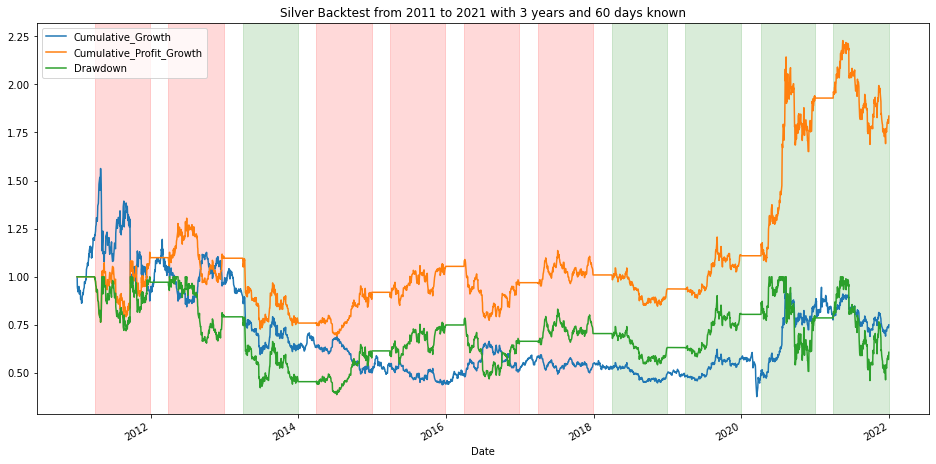

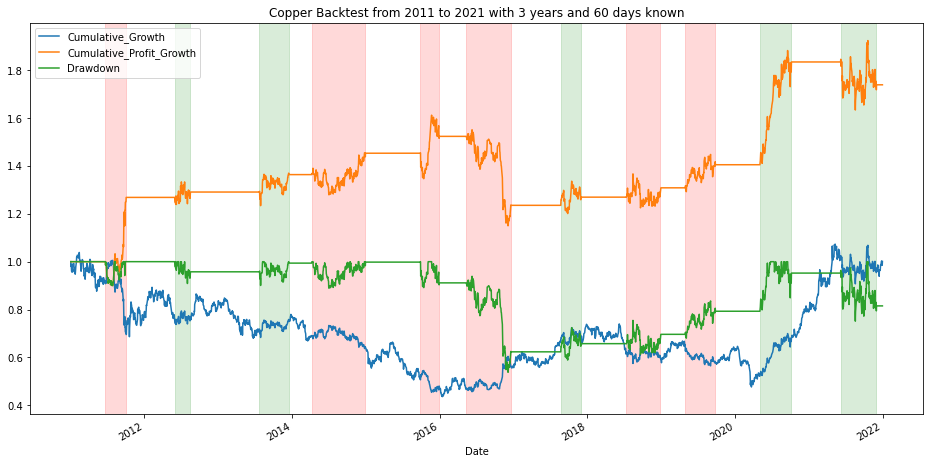

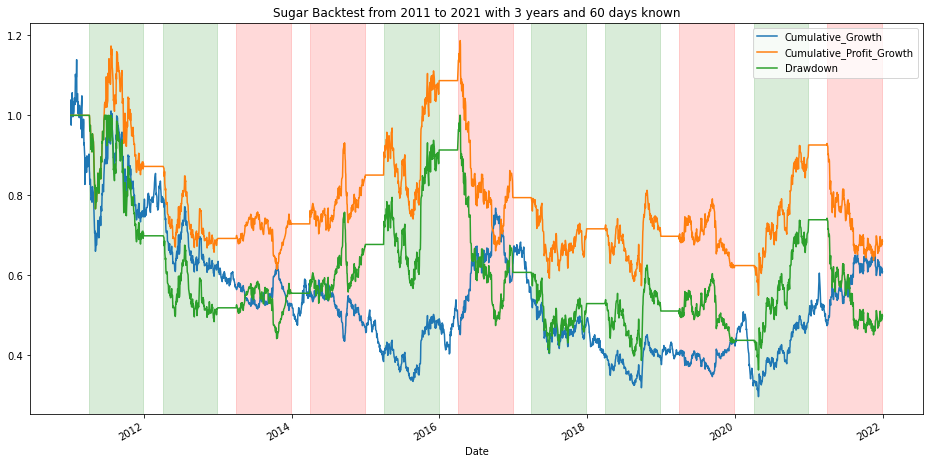

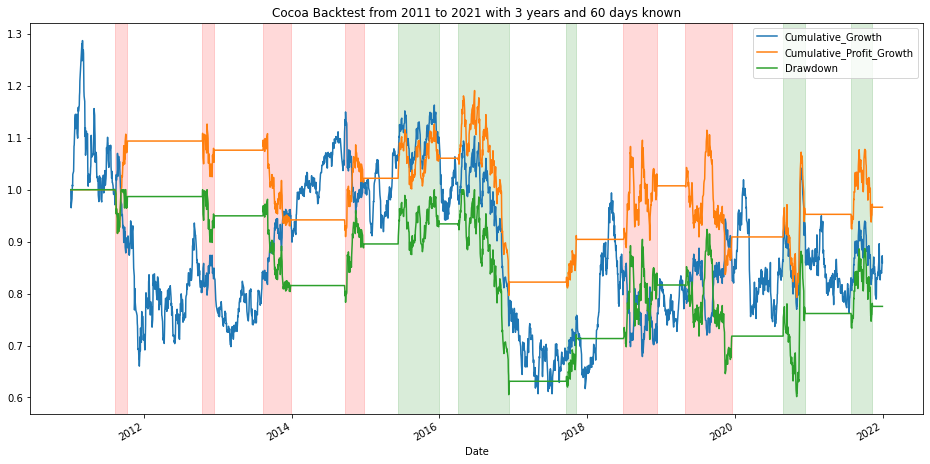

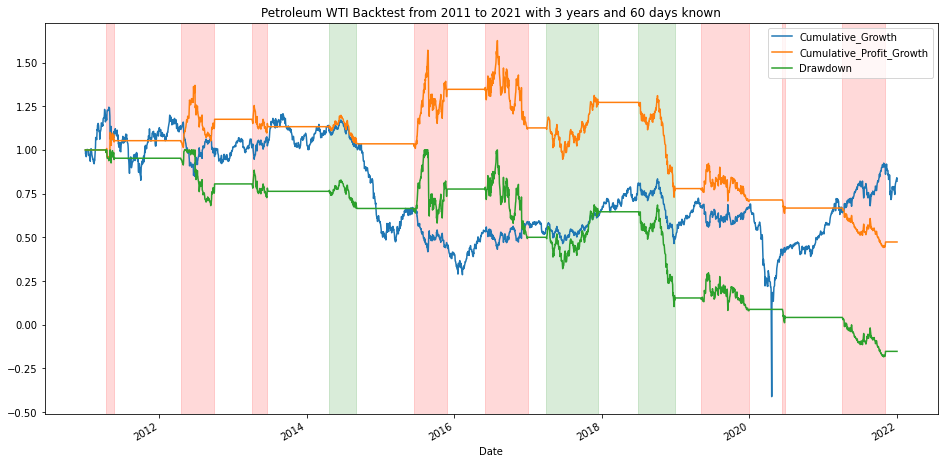

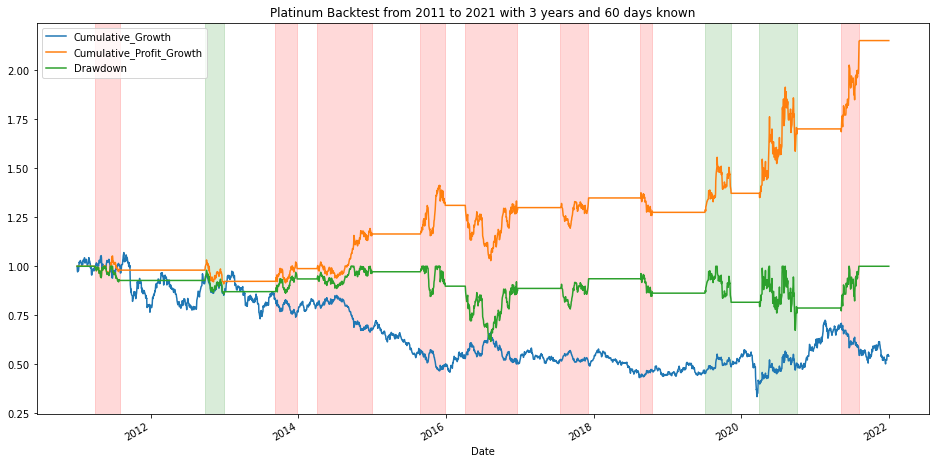

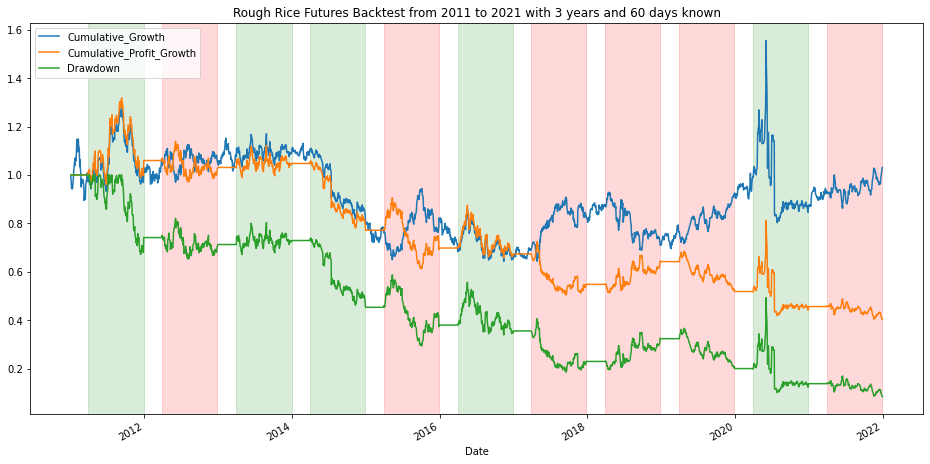

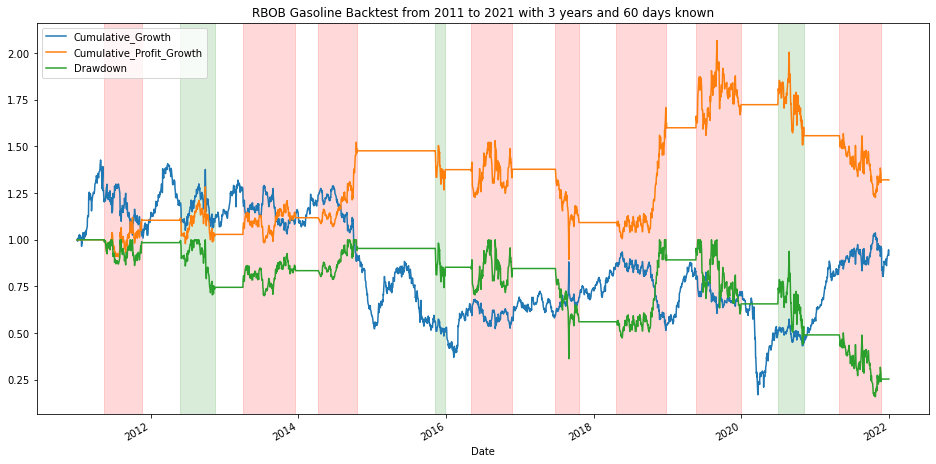

In [3]:
backtests = {}
for name in actions.keys():
    title = name + ' Backtest from {} to {} with {} years and {} days known'.format(min(years_pred), max(years_pred), years_before, days_before)
    save = name + '_{}{}_{}_{}'.format(min(years_pred), max(years_pred), days_before, years_before)
    backtest = BackTesting(df_market=actions[name].copy(), trade_col='Adj Close', action_col='Action', direction=1)
    result_backtest = backtest.execute(metrics=True, verbose=False, plot=True, title=title, save=save)
    backtests[name] = backtest

--------------- BACKTESTING ---------------
Start                   2011-01-03 00:00:00
End                     2021-12-31 00:00:00
Duration                          4015 days
Exposure time [%]                     54.51
Total ops.                              176
Buy ops.                                 81
Win rate Buy ops. [%]                 44.44
Sell ops.                                95
Win rate Sell ops. [%]                55.79
Profit [%]                            36.43
Annual yield [%]                       2.86
Profit factor                          1.05
Max. drawdown [%]                     41.29
Avg. drawdown [%]                      6.91
Recovery factor                        0.97
Determination coef. R2                 0.60
-------------------------------------------


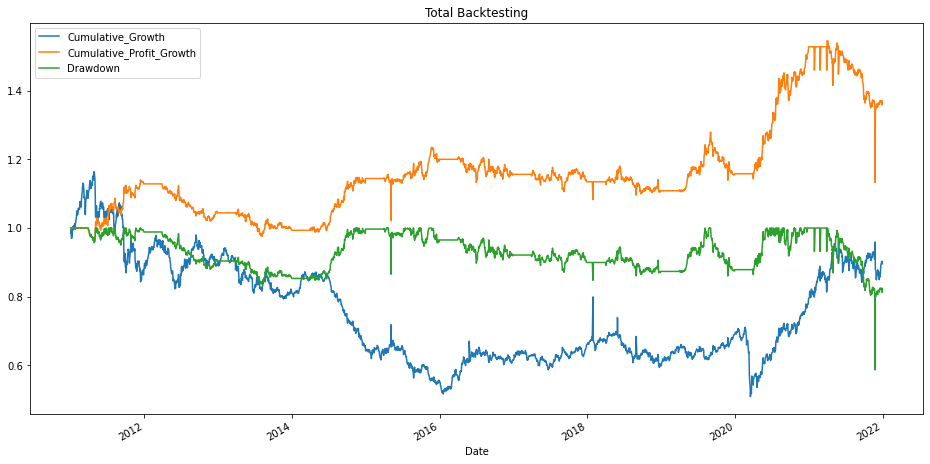

In [4]:
symbols = pd.read_csv('futures.txt', sep=';', header = 0)
total_backtest, metrics = total_backtesting(backtests, symbols, verbose=True, plot=True, save=os.getcwd()+'/Backtesting')